<a href="https://colab.research.google.com/github/dylan33smith/LunarLandingRL/blob/main/AIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

In [54]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from IPython.display import Image, display
import imageio

# **Custom Functions and Classes**

- **evaluate_policy_and_create_video** function
  - This method will take a model and an name as input and then evaluate the model, save a gif of an episode, and print the gif inline.

- **CustomCallback** class
  - This class inherits from BaseCallback and adds functionality so that training information is only printed after the thousandth step and every 10000 steps. It was made to clean up the notebook while still giving a snapshot of the training at the start and throughout.

In [38]:
def evaluate_policy_and_create_video(model, gif_name):
    '''
    This function takes a model and a file name for a gif image as input. It then evaluates the model,
    displays the results and then creates and saves a gif of an episode.

    Parameters:
    model: a model specific to the LunarLander-v2 environment.
    gif_name: file of gif created from running an episode. Saved to current folder.
    '''

    if not gif_name.endswith(".gif"):
      gif_name = gif_name + ".gif"

    # run evaluate policy to evaluate the model
    env = gym.make("LunarLander-v2")
    mean_reward, std_reward = evaluate_policy(
                                model,
                                env,
                                n_eval_episodes=10,
                                deterministic=True,
                                )

    print(f"mean_reward: {mean_reward:9.2f} +/- {std_reward:9.2f}");

    # episodes to build gif
    images = []
    obs = model.env.reset()
    img = model.env.render(mode="rgb_array")
    done = False
    while not done:
        images.append(img)
        action, _ = model.predict(obs)
        obs, _, done, _ = model.env.step(action)
        img = model.env.render(mode="rgb_array")

    # Save the images as a GIF
    imageio.mimsave(gif_name, [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

    # Display the GIF in the notebook
    display(Image(open(gif_name, 'rb').read(), format='png'))


In [61]:
# This didn't work because it didn't supress the normal output, it only ended up adding outputs at the defined steps
class CustomCallback(BaseCallback):
    # inherit from BaseCallback so custom will have all the functionality of Base with additional defined functionality
    # callbacks are a way to implement custom code at certain points in the training loop
    # custom callback to print information at intervals of 10000 steps

    # Constructor
    def __init__(self, verbose=1, print_freq=10000):
        # call constructor of patent to initialize base
        super(CustomCallback, self).__init__(verbose)
        self.print_freq = print_freq
        # keep track of steps in training process
        self.rollout_counter = 0

    # this method is called after each step in the training process
    # override _on_step method to insert custom behavior
    def _on_step(self) -> bool:
        self.rollout_counter += 1
        # only runs when step is a multiple of 10000 or on 1000
        if self.rollout_counter % self.print_freq == 0:
          print(f"Rollout {self.rollout_counter}: ", self.locals['infos'])
        return True


In [62]:
# set customcallback with defined print_freq
customcallback = CustomCallback(print_freq=20000)


# **DQN model**

The following is an implementation of a dqn (Deep Q-learning) model which uses deep neural networks to approximate the Q function. It maintains two networks, the first for the current best guess of the Q-function, and the second 'target' network that is updated less frequently and used to generate stable targets for learning.

In [16]:
# Parameters
  # MlpPolicy: multi-layer perceptron (feedforward neural net)
  # LunarLander-v2: environment on which the model will be trained
    # goal is to land the lander between two flags
  # verbose: controls how much information the model will output during training
  # exploration_final_eps: controls the epsiolon value in the epsilon greedy strategy
    # balances exploration and exploitation
    # specific to DQN
  # target_update_interval: specifies how often the target network is updated
    # every interval, the target weights are updated to match those of the main network
dqn_model = DQN(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=1,
    exploration_final_eps=0.1, # model will choose a random action with a 10% probability
    target_update_interval=250,
    )

Using cpu device
Creating environment from the given name 'LunarLander-v2'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:     -1.23 +/-     88.06


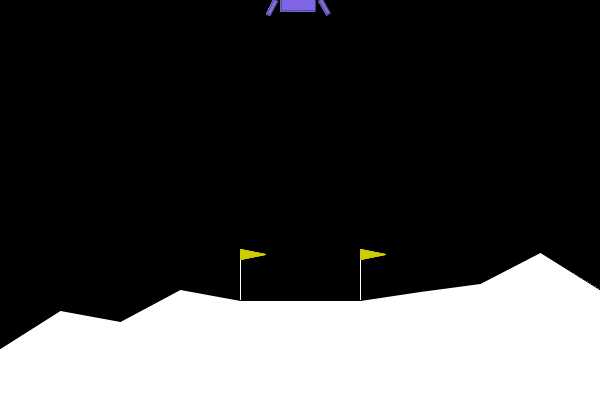

In [43]:
# Baseline initial model with random weights
gif_name = "random_dqn.gif"
evaluate_policy_and_create_video(dqn_model, gif_name);

In [ ]:
# training the DQN agent
dqn_model.learn(total_timesteps=100000)
dqn_model.save('dqn_ll')

# model.learn outputs:
  # ep_len_mean: average length of an episode
  # ep_rew_mean: average reward per episode
  # eploration_rate: current rate of exploration in epsilon greedy strategy
    # This decreases over time as model learns

# in DQN, the network weights are updated periodically based on the stored experiences.
  # each of the rollouts bellow signifies an update to the models weights


In [19]:
# Trained model
gif_name = "trained_dqn.gif"
evaluate_policy_and_create_video(model, gif_name);

mean_reward:     20.99 +/-    127.66


# **PPO Model**



In [46]:
# Parameters

ppo_model = PPO(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=1,
    )

Using cpu device
Creating environment from the given name 'LunarLander-v2'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:   -130.35 +/-     23.80


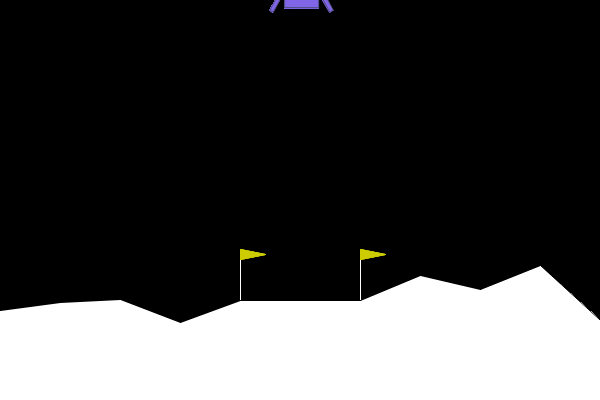

In [45]:
# Baseline initial PPO model
gif_name = "random_ppo.gif"
evaluate_policy_and_create_video(ppo_model, gif_name);

In [47]:
# training the PPO agent
ppo_model.learn(total_timesteps=100000, callback=customcallback)
ppo_model.save('ppo_ll')

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.1     |
|    ep_rew_mean     | -183     |
| time/              |          |
|    fps             | 584      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.5        |
|    ep_rew_mean          | -168        |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009396654 |
|    clip_fraction        | 0.0478      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00298    |
|    learning_rate        | 0.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:    -18.92 +/-     18.13


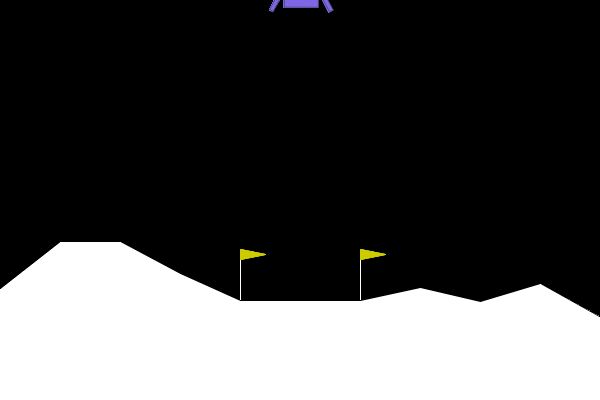

In [52]:
# Trained PPO model
gif_name = "trained_ppo.gif"
evaluate_policy_and_create_video(ppo_model, gif_name);

# **A2C Model**

In [55]:
# Parameters

a2c_model = A2C(
    "MlpPolicy",
    "LunarLander-v2",
    verbose=1,
    )

Using cpu device
Creating environment from the given name 'LunarLander-v2'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:   -649.07 +/-    191.35


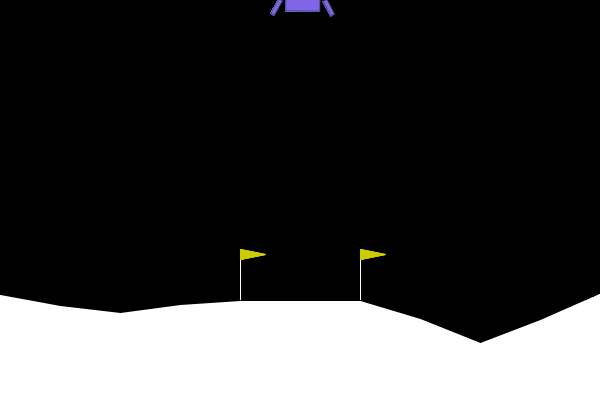

In [56]:
# Baseline initial A2C model
gif_name = "random_a2c.gif"
evaluate_policy_and_create_video(a2c_model, gif_name);

In [60]:
# training the A2C agent
a2c_model.learn(total_timesteps=100000, callback=customcallback)
a2c_model.save('a2c_ll')

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 92.8     |
|    ep_rew_mean        | -376     |
| time/                 |          |
|    fps                | 489      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.987   |
|    explained_variance | -0.0331  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -5.08    |
|    value_loss         | 106      |
------------------------------------
Rollout 1000:  [{'TimeLimit.truncated': False}]
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 98       |
|    ep_rew_mean        | -445     |
| time/                 |          |
|    fps                | 465      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:    -74.20 +/-     56.59


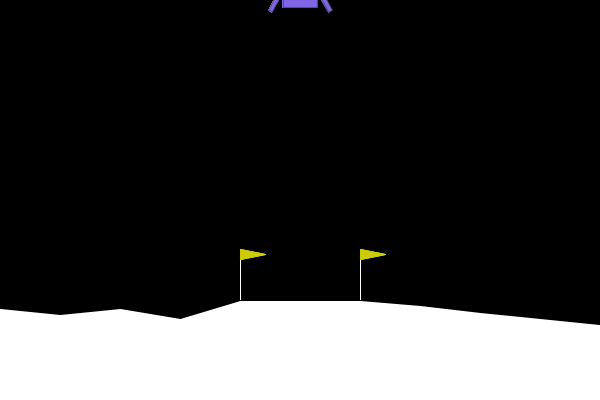

In [63]:
# Baseline initial PPO model
gif_name = "trained_a2c.gif"
evaluate_policy_and_create_video(a2c_model, gif_name);